# EDA & Data Cleaning — Seoul Bike Sharing Demand

Goal:
1) Explore the raw dataset (overview, target distribution, missingness/outliers, feature–target relationships)
2) Clean the dataset using `clean_seoul_bike_data`
3) Explore and analyse explantory data
3) Save a reproducible cleaned parquet to `data/processed/`

In [1]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# make src importable
repo_root = Path.cwd().resolve()
if repo_root.name == "notebooks":
    repo_root = repo_root.parent
sys.path.insert(0, str(repo_root / "src"))

repo_root

PosixPath('/Users/liyan/d100_d400_code_1149Z')

In [3]:
from bike_demand.data.load_data import load_data

df_raw = load_data()
df_raw.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Data overview
We inspect dataset size, column names, dtypes, and summary statistics.

In [4]:
# shape + columns
df_raw.shape, df_raw.columns.tolist()[:10]

((8760, 14),
 ['Date',
  'Rented Bike Count',
  'Hour',
  'Temperature(°C)',
  'Humidity(%)',
  'Wind speed (m/s)',
  'Visibility (10m)',
  'Dew point temperature(°C)',
  'Solar Radiation (MJ/m2)',
  'Rainfall(mm)'])

In [ ]:
# info / dtypes
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [6]:
# numeric describe
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,704.602055,644.997468,0.0,191.00,504.50,1065.25,3556.00
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
Temperature(°C),8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
Humidity(%),8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
Wind speed (m/s),8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
Visibility (10m),8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
Dew point temperature(°C),8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
Solar Radiation (MJ/m2),8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
Rainfall(mm),8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
Snowfall (cm),8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80


In [7]:
#categorical describe
df_raw.select_dtypes(include=["object", "category"]).describe().T

,count,unique,top,freq
Date,8760,365,01/12/2017,24
Seasons,8760,4,Spring,2208
Holiday,8760,2,No Holiday,8328
Functioning Day,8760,2,Yes,8465


## Data cleaning plan 

Based on the raw data inspection above:

- The dataset contains 8,760 hourly observations (365 × 24) and no missing values.
- `Date` is stored as an object and should be parsed into a proper datetime.
- Column names contain spaces and units; we standardise them to snake_case for robust downstream use.
- Categorical variables (`Seasons`, `Holiday`, `Functioning Day`) are stored as strings; we convert them to `category`.
- We retain extreme weather values as they are plausible and informative for demand prediction.

In [8]:
from bike_demand.preprocessing import clean_seoul_bike_data

df_clean = clean_seoul_bike_data(df_raw)

print(df_clean.shape)
df_clean.info()
df_clean.head()



(8760, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               8760 non-null   datetime64[ns]
 1   rented_bike_count  8760 non-null   int64         
 2   hour               8760 non-null   int16         
 3   temperature        8760 non-null   float64       
 4   humidity           8760 non-null   int64         
 5   wind_speed         8760 non-null   float64       
 6   visibility         8760 non-null   int64         
 7   dew_point_temp     8760 non-null   float64       
 8   solar_radiation    8760 non-null   float64       
 9   rainfall           8760 non-null   float64       
 10  snowfall           8760 non-null   float64       
 11  seasons            8760 non-null   category      
 12  holiday            8760 non-null   category      
 13  functioning_day    8760 non-null   category      
 1

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temp,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day,month,day_of_week
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,4
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,4
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,12,4
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,4
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,4


## Exploratory analysis on cleaned data

After standardising the dataset schema, we conduct exploratory analysis on the cleaned data to:
- understand the target distribution,
- identify potential outliers (without necessarily removing them),
- examine relationships between key features and rental demand,
- uncover temporal and seasonal patterns that may inform feature engineering and model choice.


/Users/liyan/miniconda3/envs/d400final/lib/python3.13/site-packages/dalex/_global_checks.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


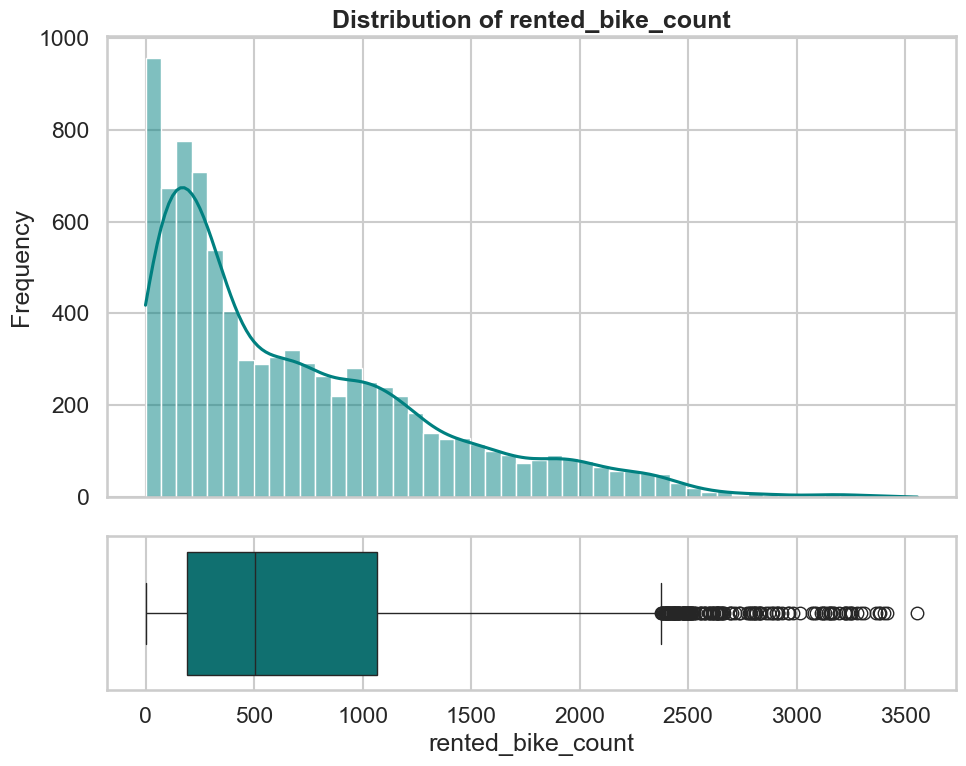

In [9]:

# Target distribution
from bike_demand.plotting import plot_target_distribution

plot_target_distribution(df_clean, target_col="rented_bike_count")
plt.show()


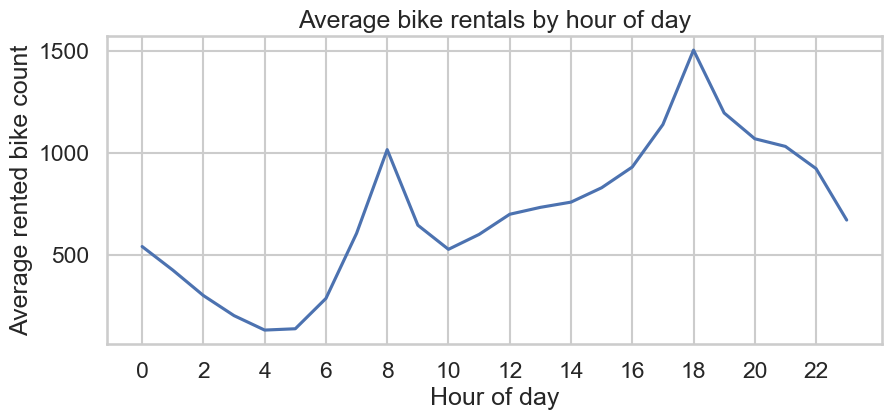

In [10]:
#hourly pattern of target variable
import matplotlib.pyplot as plt

hourly = df_clean.groupby("hour", observed=True)["rented_bike_count"].mean()

plt.figure(figsize=(10, 4))
plt.plot(hourly.index, hourly.values)
plt.title("Average bike rentals by hour of day")
plt.xlabel("Hour of day")
plt.ylabel("Average rented bike count")
plt.xticks(range(0, 24, 2))
plt.show()


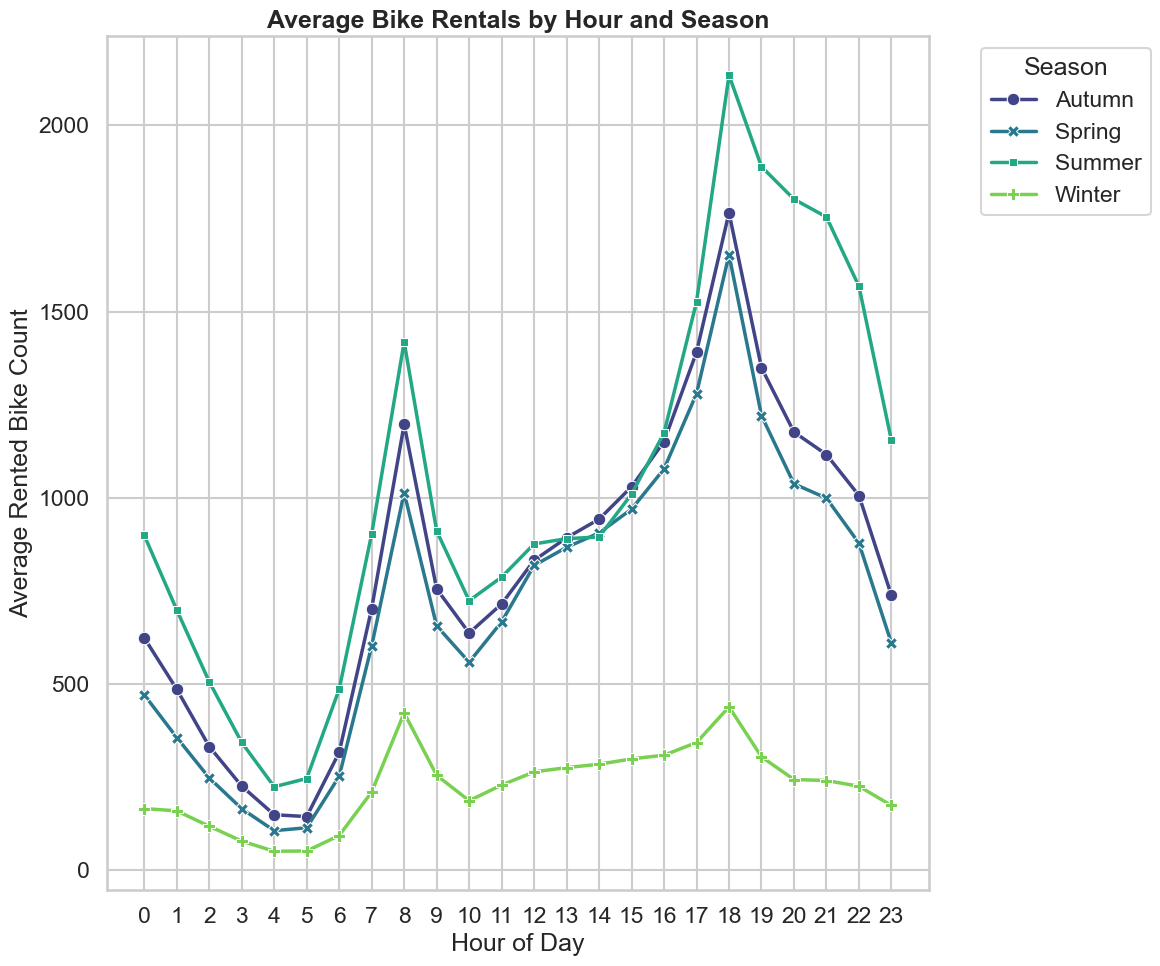

In [11]:
from bike_demand.plotting import plot_hourly_trend_by_season

plot_hourly_trend_by_season(df_clean)
plt.show()


## Distribution of key variables

We examine the marginal distributions of selected variables to assess
skewness, zero inflation, and scale differences that may affect model
choice and feature engineering.


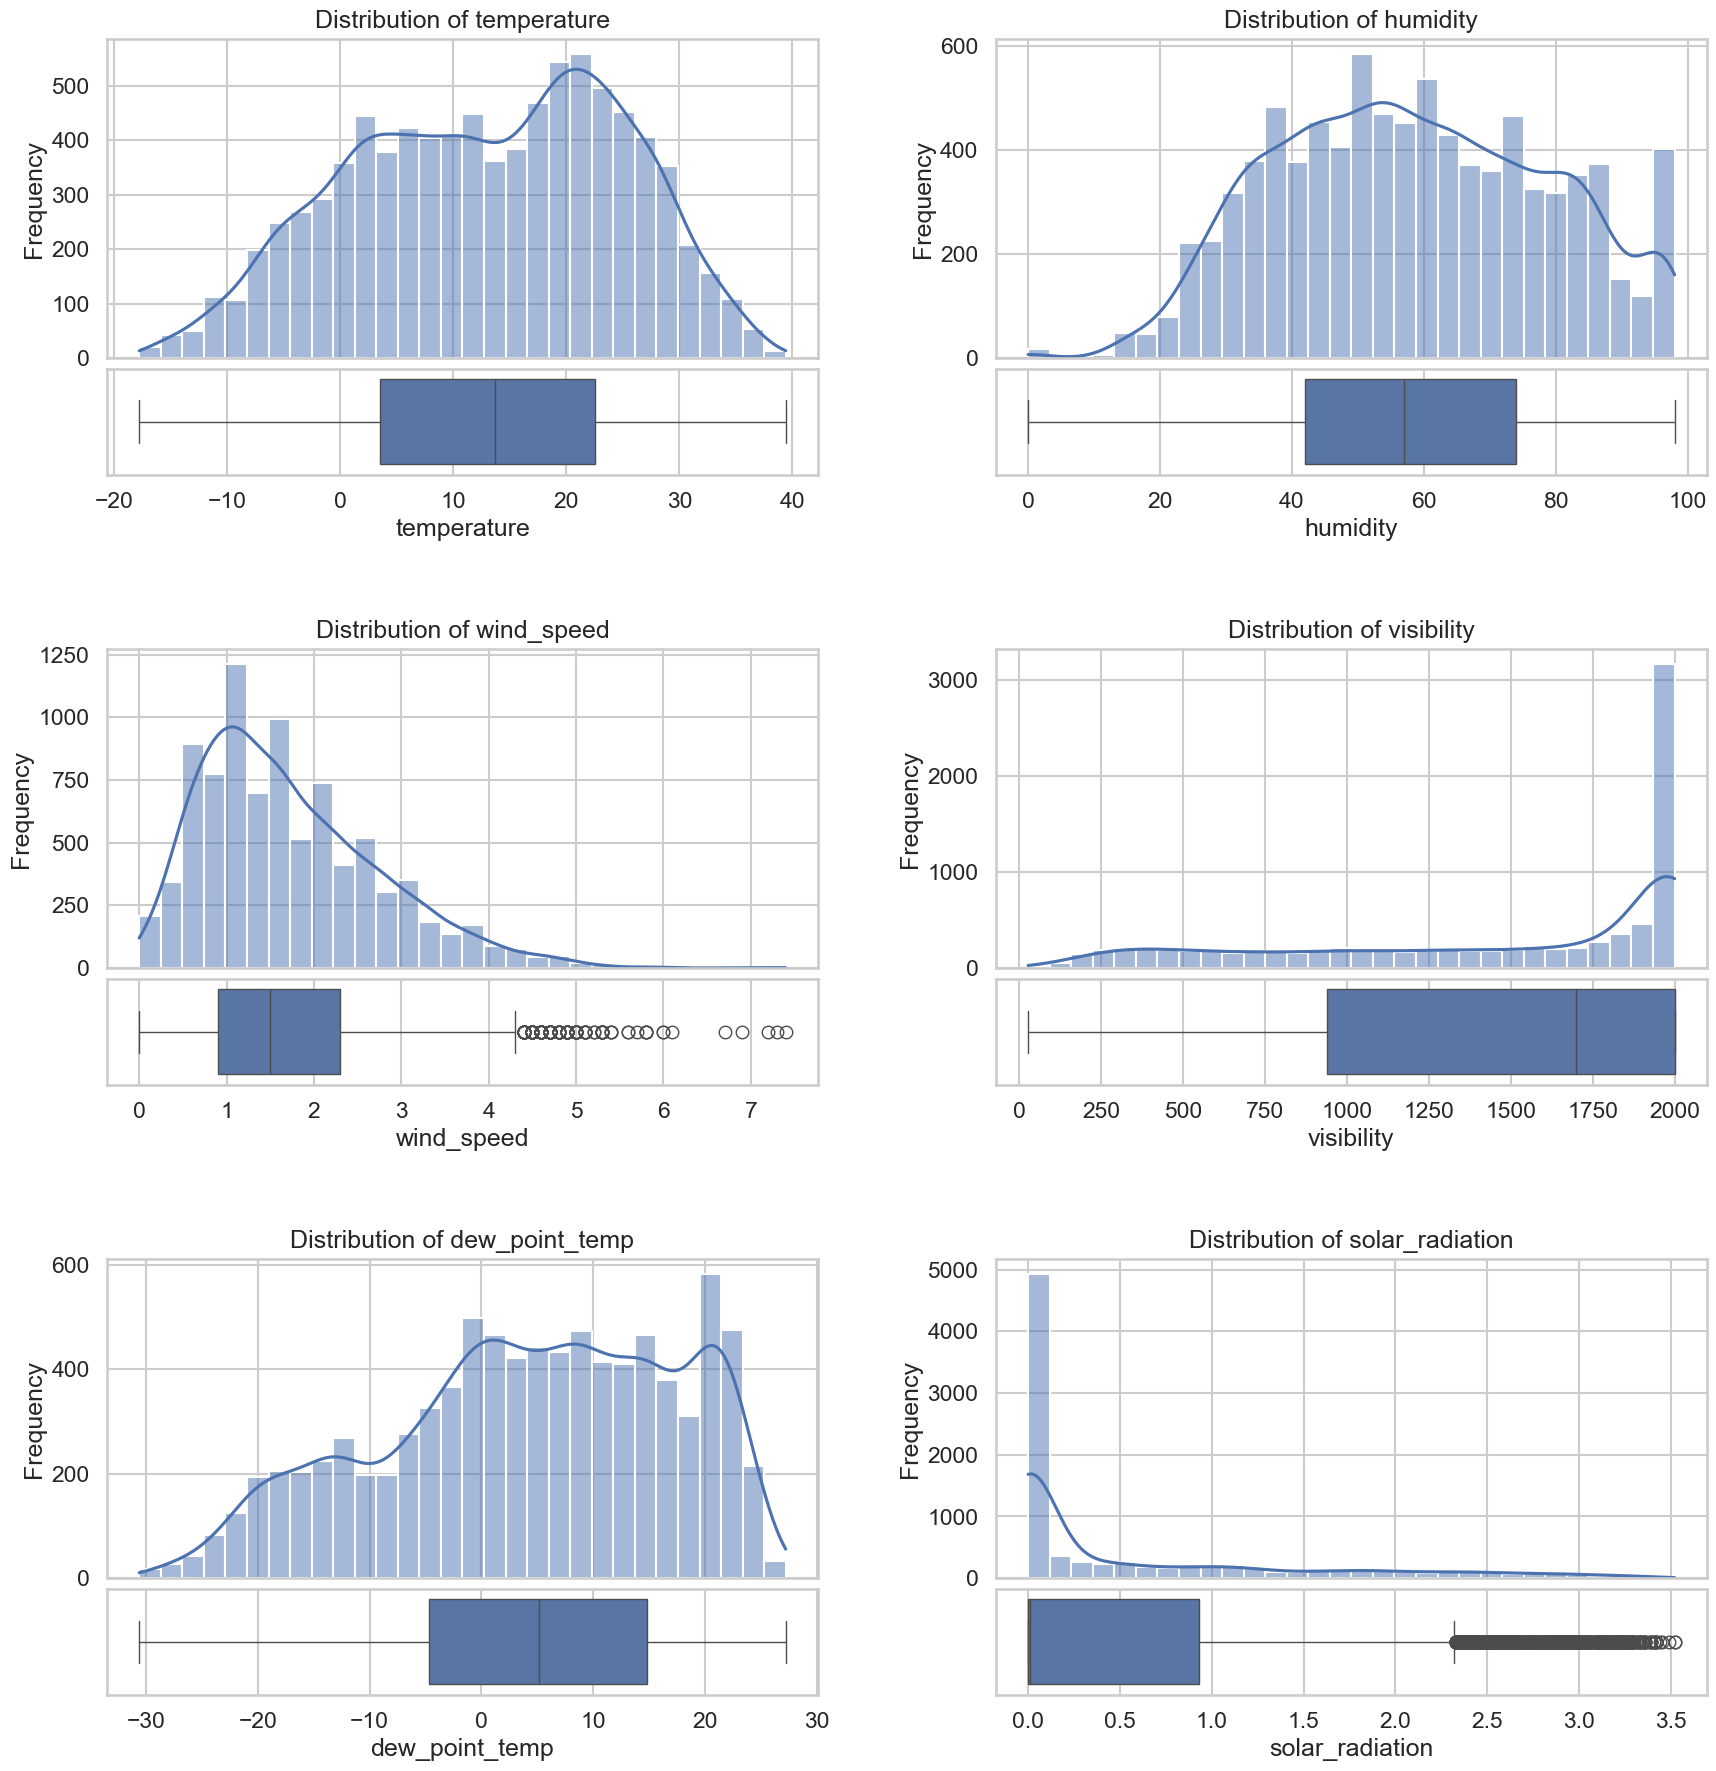

In [12]:
from bike_demand.plotting import plot_combined_explanatory_distributions

vars_to_plot = [
    "temperature",
    "humidity",
    "wind_speed",
    "visibility",
    "dew_point_temp",
    "solar_radiation",
]

plot_combined_explanatory_distributions(
    df_clean, 
    vars_to_plot, 
    bins=30, 
    kde=True
)
plt.show()

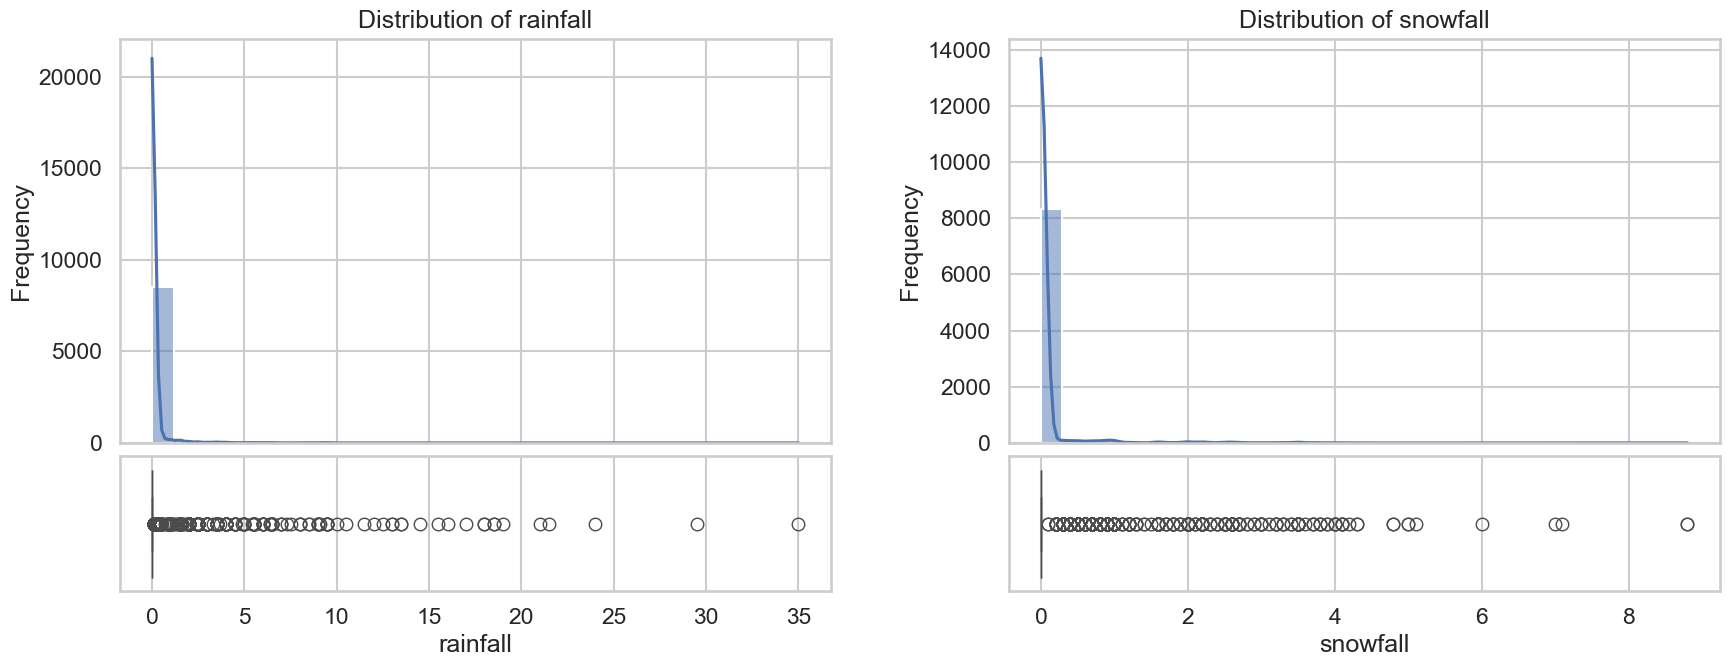

In [13]:
vars_to_plot2 = [
    "rainfall",
    "snowfall",
   
]

plot_combined_explanatory_distributions(
    df_clean, 
    vars_to_plot2, 
    bins=30, 
    kde=True
)
plt.show()


In [14]:
df_clean["rain_binary"] = (df_clean["rainfall"] > 0).astype(int)
rain_occurrence_table = (
    df_clean["rain_binary"]
    .value_counts()
    .rename(index={0: "No Rainfall", 1: "Rainfall > 0"})
    .to_frame(name="Count")
)

rain_occurrence_table["Proportion"] = (
    rain_occurrence_table["Count"] / rain_occurrence_table["Count"].sum()
)

rain_occurrence_table


,Count,Proportion
rain_binary,,
No Rainfall,8232,0.939726
Rainfall > 0,528,0.060274


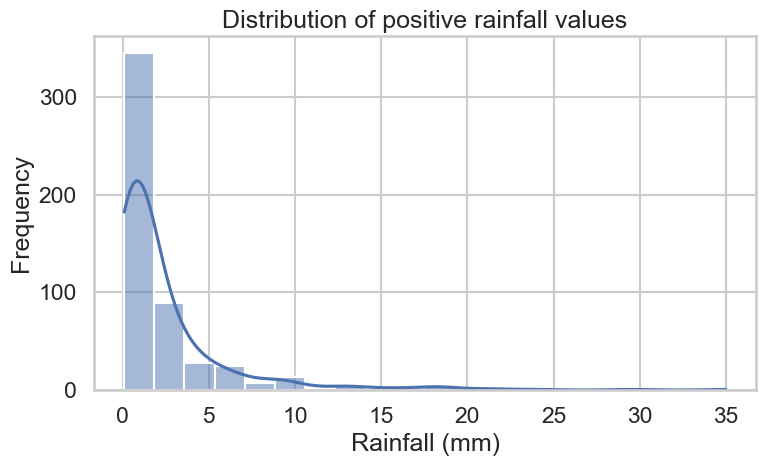

In [15]:
rain_pos = df_clean.loc[df_clean["rainfall"] > 0, "rainfall"]

plt.figure(figsize=(8, 5))
sns.histplot(rain_pos, bins=20, kde=True)
plt.title("Distribution of positive rainfall values")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [16]:
df_clean["snow_binary"] = (df_clean["snowfall"] > 0).astype(int)
snow_occurrence_table = (
    df_clean["snow_binary"]
    .value_counts()
    .rename(index={0: "No Snowfall", 1: "Snowfall > 0"})
    .to_frame(name="Count")
)

snow_occurrence_table["Proportion"] = (
    snow_occurrence_table["Count"] / snow_occurrence_table["Count"].sum()
)

snow_occurrence_table

,Count,Proportion
snow_binary,,
No Snowfall,8317,0.949429
Snowfall > 0,443,0.050571


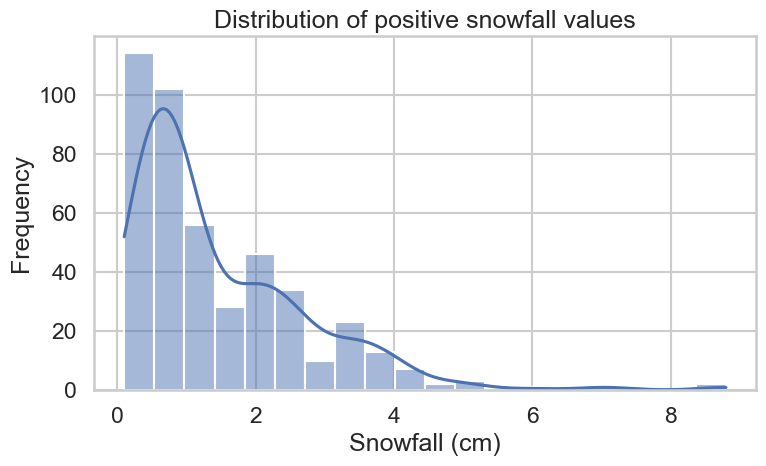

In [17]:
snow_pos = df_clean.loc[df_clean["snowfall"] > 0, "snowfall"]

plt.figure(figsize=(8, 5))
sns.histplot(snow_pos, bins=20, kde=True)
plt.title("Distribution of positive snowfall values")
plt.xlabel("Snowfall (cm)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



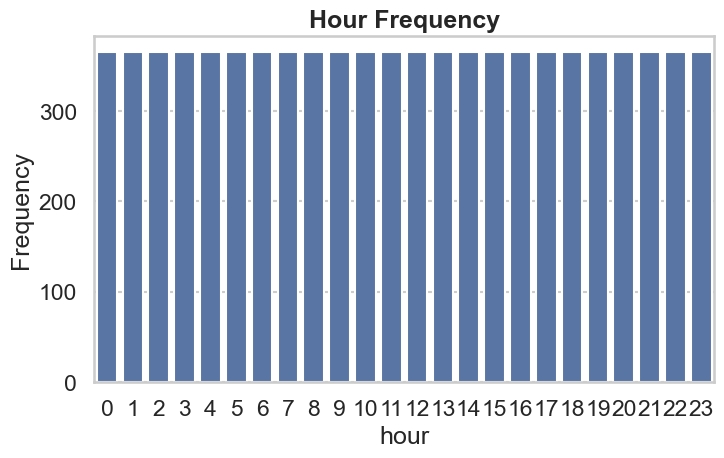

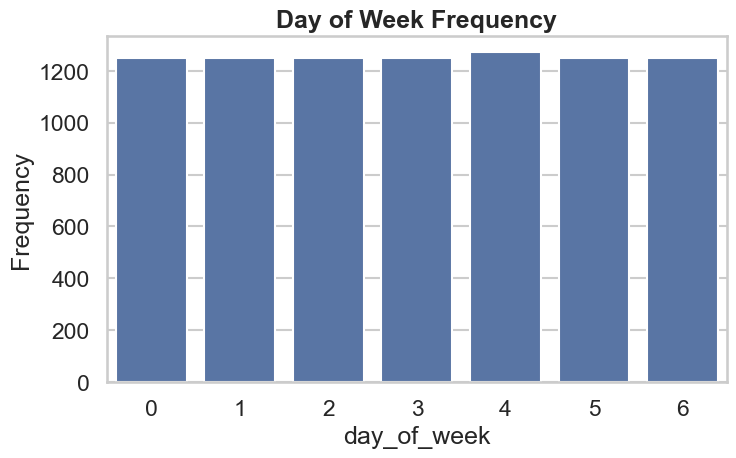

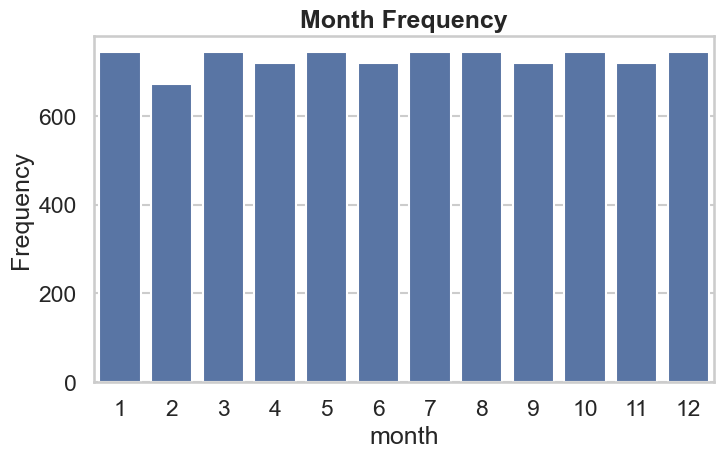

In [18]:
from bike_demand.plotting import plot_categorical_frequency
plot_categorical_frequency(
    df_clean,
    col="hour",
    order=list(range(24)),
    title="Hour Frequency"
)
plt.show()

plot_categorical_frequency(
    df_clean,
    col="day_of_week",
    order=list(range(7)),
    title="Day of Week Frequency"
)
plt.show()

plot_categorical_frequency(
    df_clean,
    col="month",
    order=list(range(1,13)),
    title="Month Frequency"
)
plt.show()

seasons
Spring    2208
Summer    2208
Autumn    2184
Winter    2160
Name: count, dtype: int64


/Users/liyan/d100_d400_code_1149Z/src/bike_demand/plotting.py:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


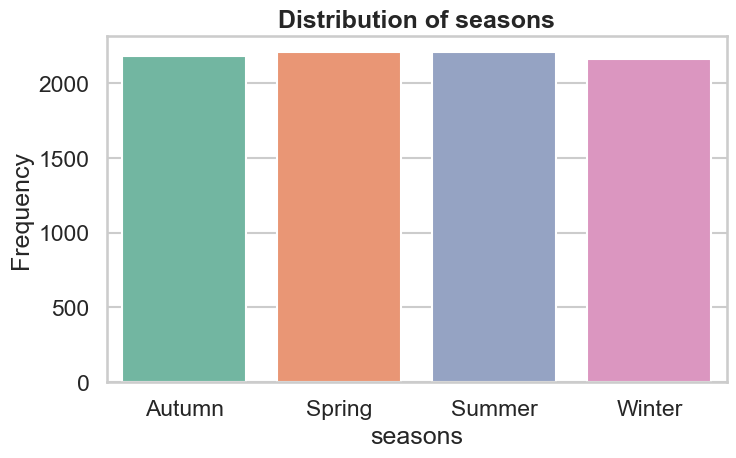

holiday
No Holiday    8328
Holiday        432
Name: count, dtype: int64


/Users/liyan/d100_d400_code_1149Z/src/bike_demand/plotting.py:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


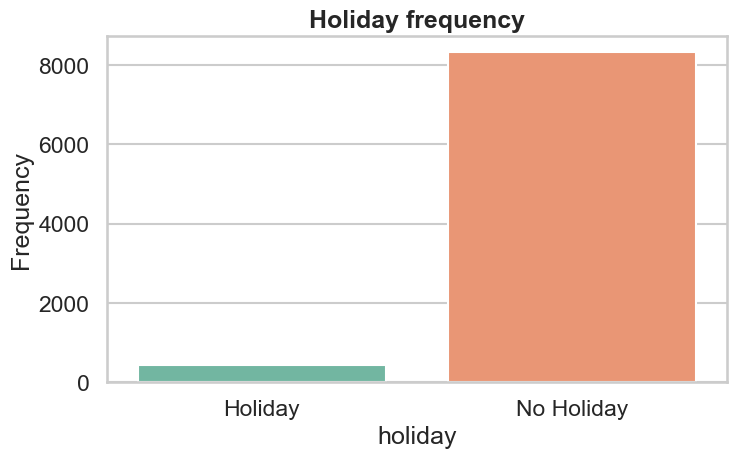

functioning_day
Yes    8465
No      295
Name: count, dtype: int64


/Users/liyan/d100_d400_code_1149Z/src/bike_demand/plotting.py:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


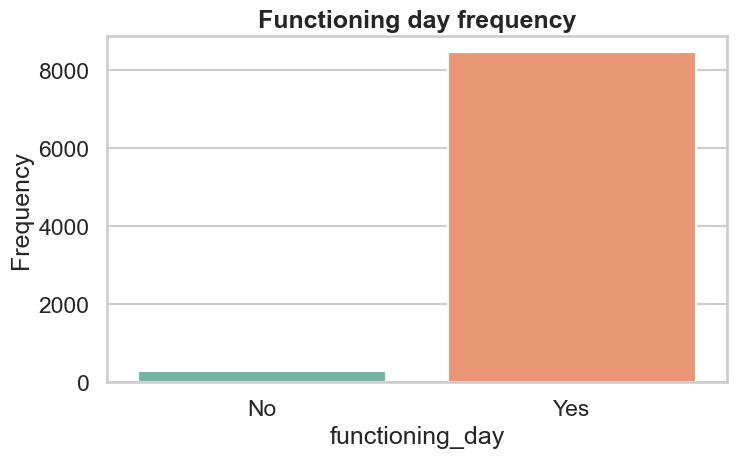

In [19]:
# 1. seasons
plot_categorical_frequency(
    df_clean,
    col='seasons',
    title='Distribution of seasons',
    palette='Set2'
)

print(df_clean["seasons"].value_counts())
plt.show()


# 2. holiday
plot_categorical_frequency(
    df_clean,
    col='holiday',
    title='Holiday frequency',
    palette='Set2'
)

print(df_clean["holiday"].value_counts())
plt.show()


# 3. functioning_day
plot_categorical_frequency(
    df_clean,
    col='functioning_day',
    title='Functioning day frequency',
    palette='Set2'
)

print(df_clean["functioning_day"].value_counts())
plt.show()


In [20]:
# Correlation 
num_cols = [
    "temperature","humidity","wind_speed","visibility","dew_point_temp",
    "solar_radiation","rainfall","snowfall",
    "month","day_of_week","hour"
]

corr = df_clean[num_cols + ["rented_bike_count"]].corr(numeric_only=True)["rented_bike_count"].sort_values(ascending=False)
corr


rented_bike_count    1.000000
temperature          0.538558
hour                 0.410257
dew_point_temp       0.379788
solar_radiation      0.261837
visibility           0.199280
month                0.133514
wind_speed           0.121108
day_of_week         -0.029357
rainfall            -0.123074
snowfall            -0.141804
humidity            -0.199780
Name: rented_bike_count, dtype: float64

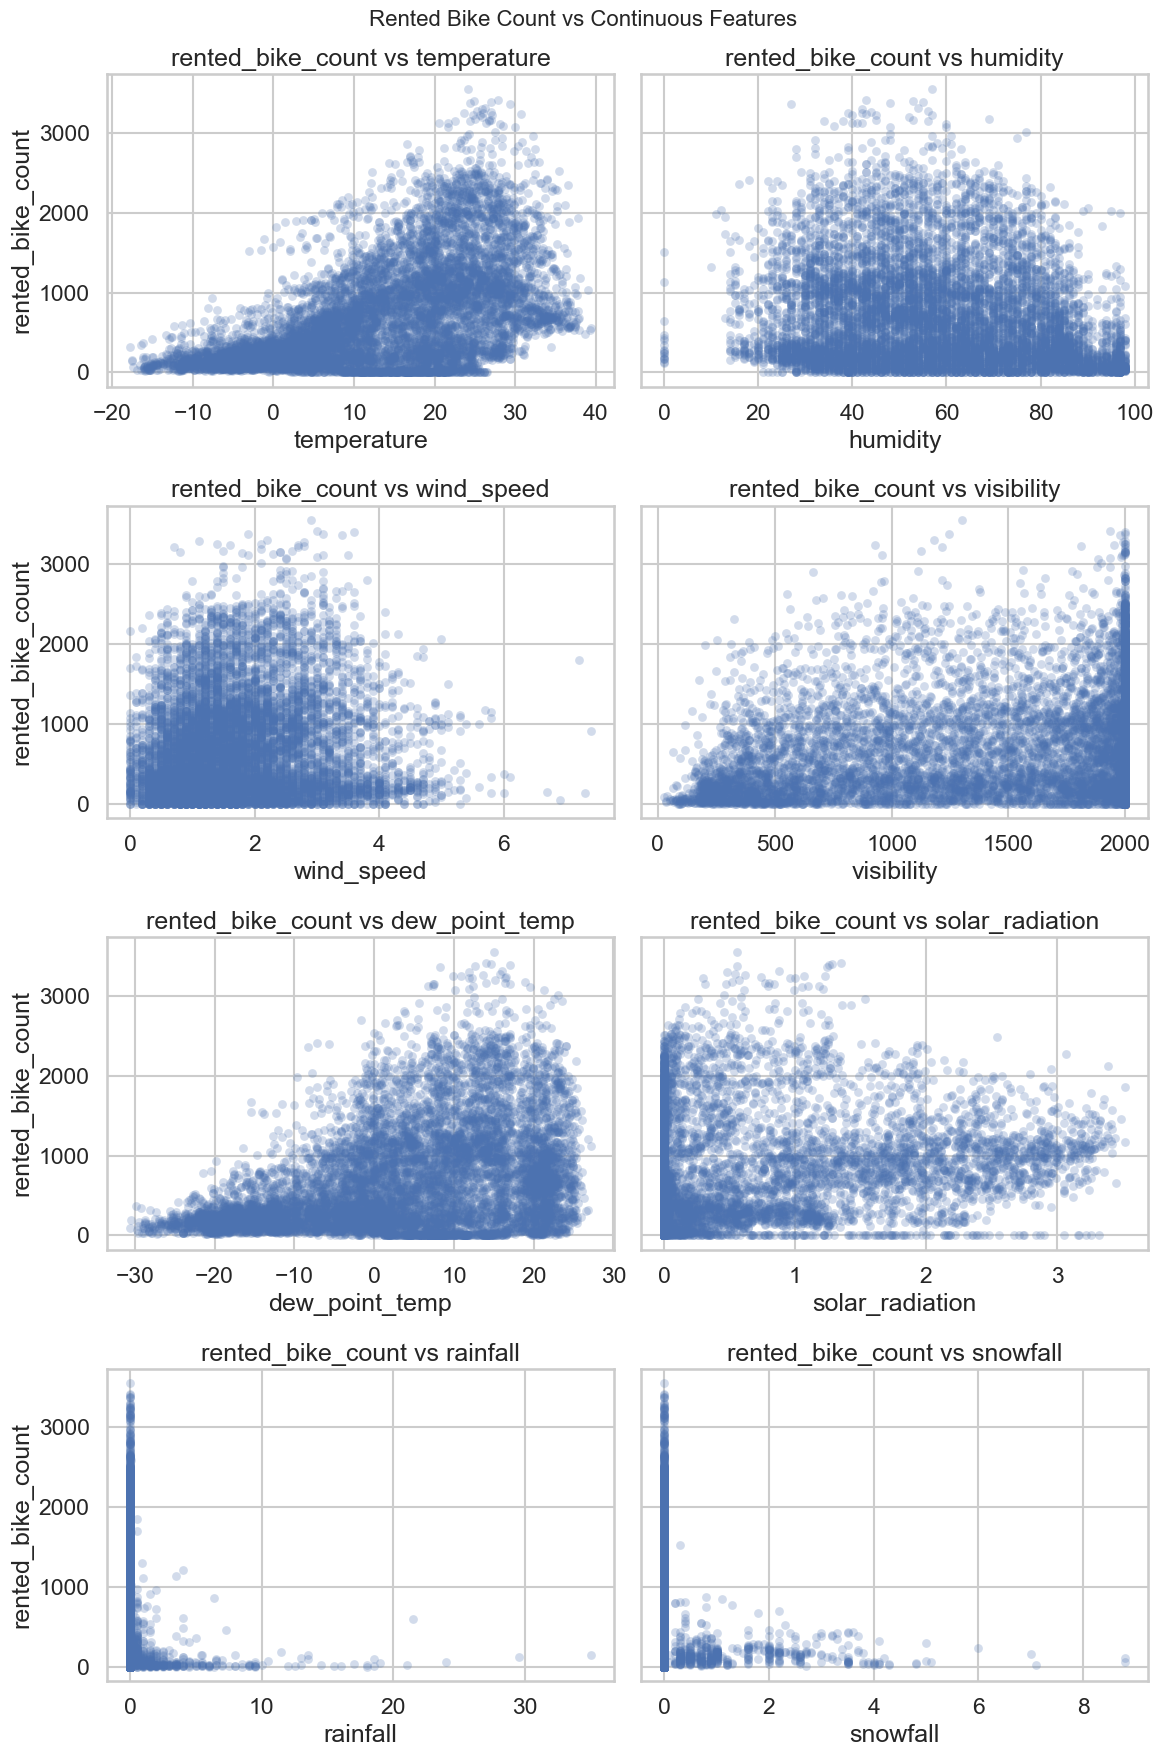

In [21]:
from bike_demand.plotting import plot_target_vs_continuous
continuous_feature = [
    "temperature",
    "humidity",
    "wind_speed",
    "visibility",
    "dew_point_temp",
    "solar_radiation",
    "rainfall",
    "snowfall",
]


plot_target_vs_continuous(df_clean, continuous_feature)


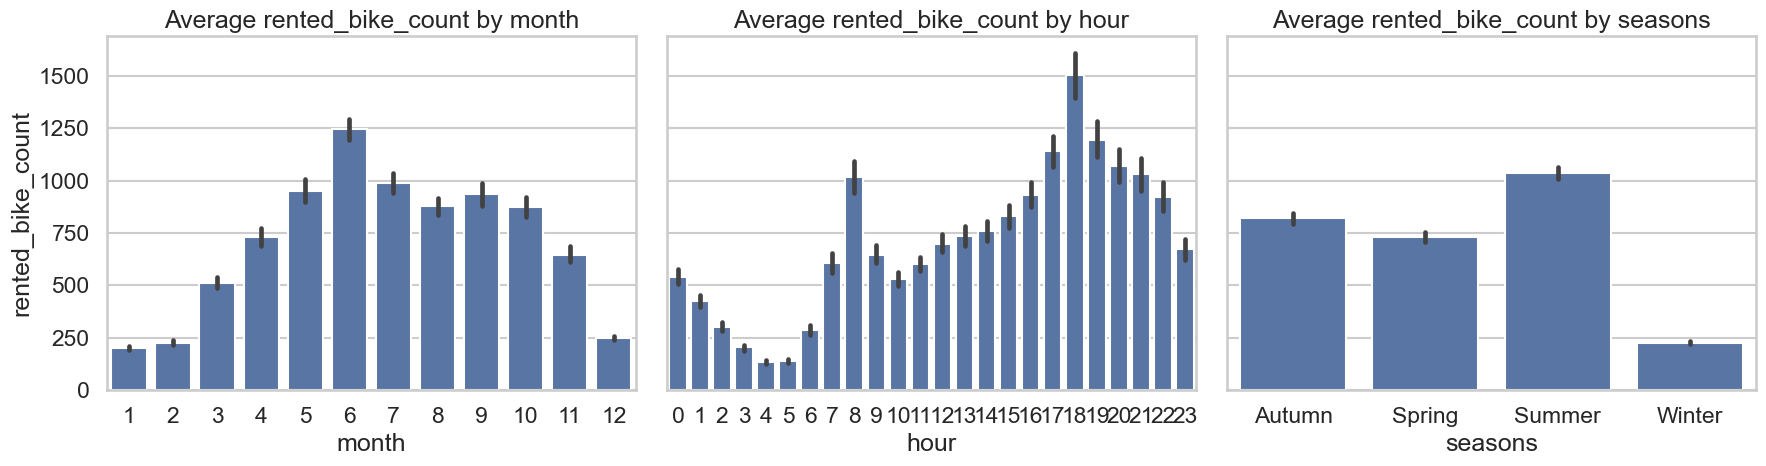

In [22]:
from bike_demand.plotting import plot_target_vs_categorical_mean

temporal_categorical_features = [
    "month",
    "hour",
    "seasons"
]

plot_target_vs_categorical_mean(df_clean, temporal_categorical_features, ncols=3)



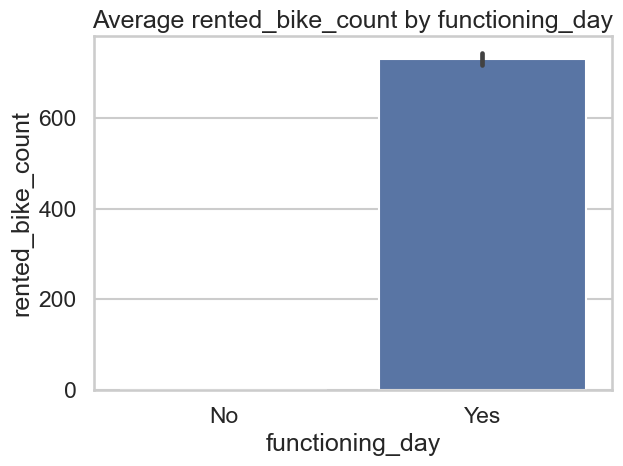

In [23]:
categorical_indicators = [
   "functioning_day"
]

plot_target_vs_categorical_mean(df_clean, categorical_indicators, ncols=2)

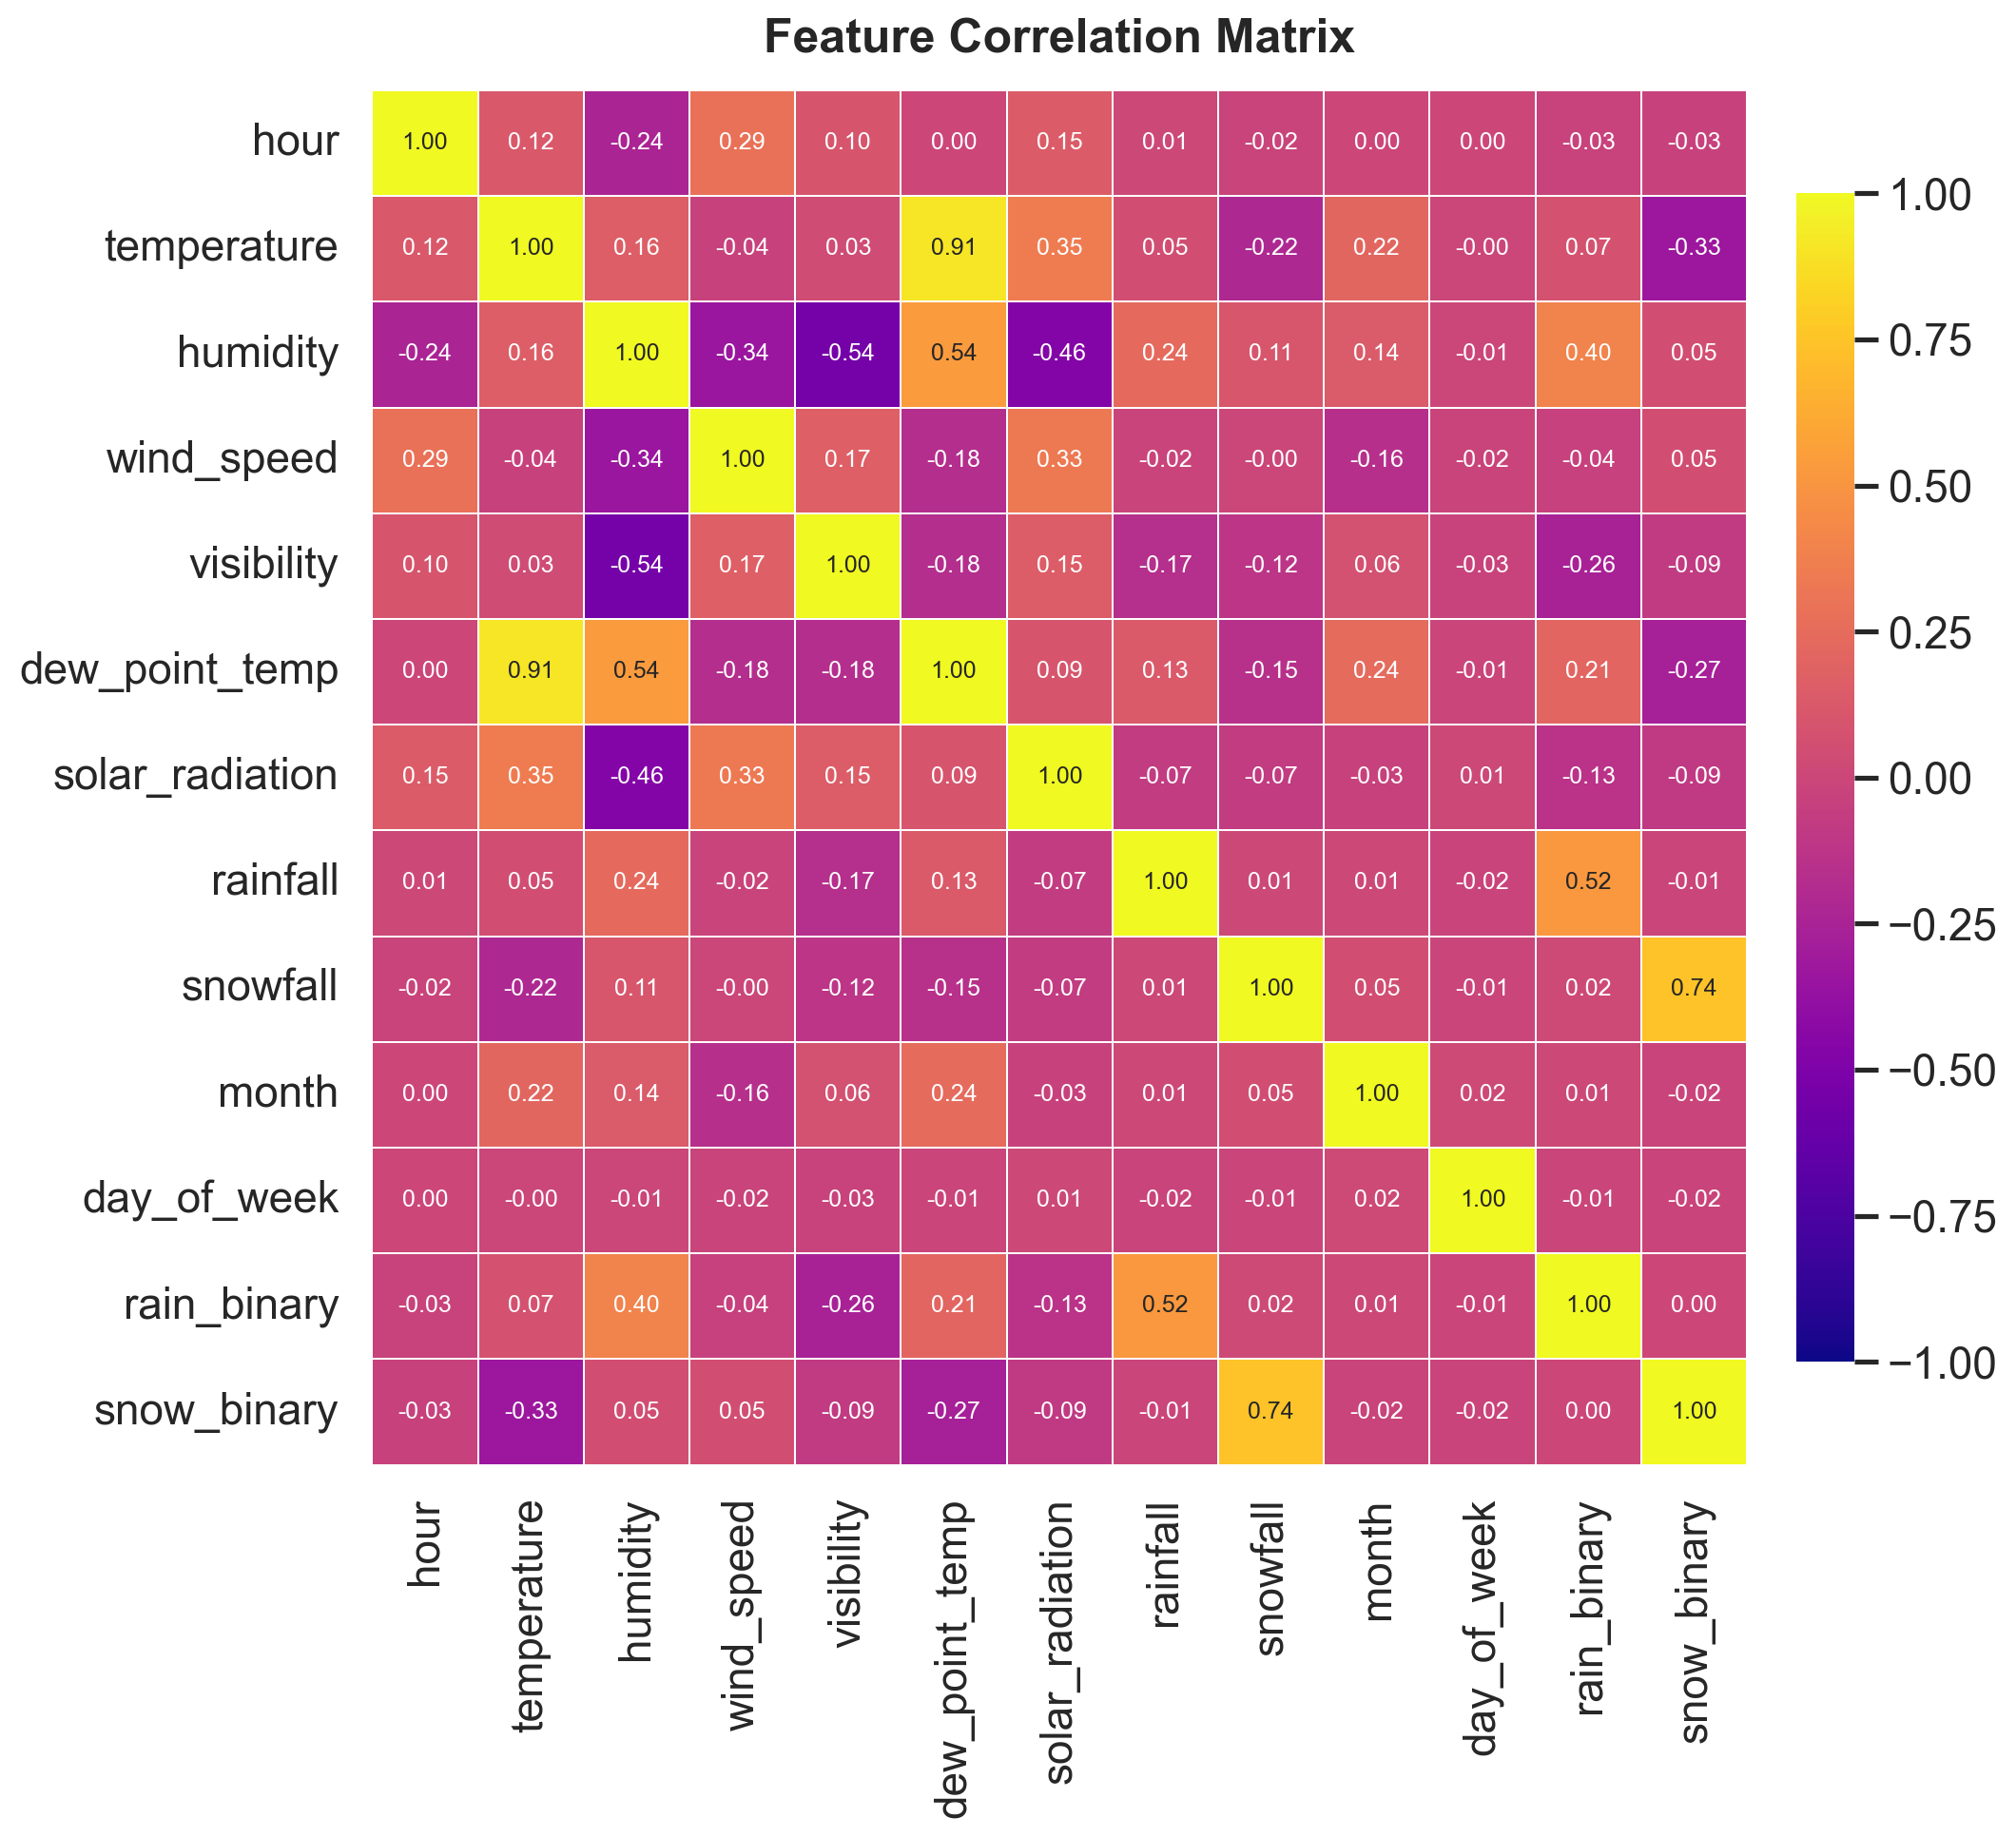

In [24]:
from bike_demand.plotting import plot_correlation_heatmap

# Exclude target and obvious identifiers
corr = plot_correlation_heatmap(
    df_clean,
    exclude_cols=["rented_bike_count", "date"],

)

In [25]:
from bike_demand.preprocessing import save_processed_data

save_processed_data(df_clean)


Saving columns: ['date', 'rented_bike_count', 'hour', 'temperature', 'humidity', 'wind_speed', 'visibility', 'dew_point_temp', 'solar_radiation', 'rainfall', 'snowfall', 'seasons', 'holiday', 'functioning_day', 'month', 'day_of_week', 'rain_binary', 'snow_binary']
Saving to: /Users/liyan/d100_d400_code_1149Z/data/processed/seoul_bike_cleaned.parquet


PosixPath('/Users/liyan/d100_d400_code_1149Z/data/processed/seoul_bike_cleaned.parquet')